In [ ]:
from models import train_predict,CondensedGoogLeNet
from models.train_predict import get_confusion_matrix
from data.data_processing import generate_dummy_data,DataHandler,get_training_data_from_path
from config.hyperparams import GoogleNet_hyperparams
from backtest.backtest import Backtester


import tensorflow as tf
import pandas as pd
import numpy as np
import os

%load_ext autoreload
%autoreload 2
%matplotlib inline

In [ ]:
folder_for_samples = 'data/cnn_samples'

# Data Processing

## Get stock data in Handler object

In [ ]:
path_to_dump_samples = os.path.join(folder_for_samples,'regular')

handler = DataHandler(encoding_method='GADF', window_len=64, image_size=32, retrain_freq=5,
                 start_date = 20150801, end_date= 20200102, frac_of_stocks=0.3,
                stock_data_dir_path= 'data/2019_stock_data',targets_methods=['close'],
                 dir_for_samples=path_to_dump_samples, nb_of_stocks_by_file=100,
                      kwargs_target_methods = {'up_return':0.012,'down_return':-0.012,'buy_on_last_date':True}
                 )

In [ ]:
handler.get_df_data()

In [ ]:
# handler.show_image(handler.df_data)

## Builds images and targets and creates pickles
+ Be careful for the folder name (specified in handler object), this function will delete all files in this folder before dumping pickles

In [ ]:
handler.build_and_dump_images_and_targets()

# Training

## Retrieve data from the specified folder
+ '/regular' is the default to retrieve samples
+ '/VWAP_1_week_2015_2017_all_stocks' is another one

In [ ]:
%%time

path_to_retrieve_samples = folder_for_samples+'/regular'

X_train, X_val, X_test, Y_train, Y_val, Y_test = get_training_data_from_path(samples_path=path_to_retrieve_samples,
                                targets_type='close',
                                train_val_size=2 / 3.,
                                train_size=0.75,
                                logger_env='Training')


## Build the neural network object and Train the network 
+ Choose your params BE CAREFUL about the path to drop the model_checkpoints
+ Choose or update hyperparameters
+ If you run restore = True Choose the checkpoint.meta file to use for the model to load

###### Then 

+ Choose parameters for the train_predict function 
+ Run the next cell to build the network object and train

In [5]:
shape_x,shape_y = list(X_train.shape),list(Y_train.shape)
shape_x[0],shape_y[0] = None,None

GoogleNet_hyperparams.update({'learning_rate':0.003,'dropout':0.20})

# penalty factor assigned for misclassifying i to j. It used to combine sample prior (distribution of classes in the training
# sample) to compute expected penalty of misclassifying i-th class
cost_matrix=np.array([[0, 1.1, 1.4], [1.1, 0, 1.1], [1.4, 1.1, 0]])

n_test = 10000
checkpoints_folder = 'model_checkpoints'
checkpoint_prefix = 'ckpt-VWAP-1_week-2015_2017-32_pixels'
model_checkpoints_path = os.path.join(checkpoints_folder,checkpoint_prefix)

# X_train1, X_val1, Y_train1, Y_val1 =  X_train[:n_test], X_val[:n_test], Y_train[:n_test], Y_val[:n_test]
# X_train1, X_val1, Y_train1, Y_val1 =  X_train[n_test:], X_val[:n_test], Y_train[n_test:], Y_val[:n_test]
X_train1, X_val1, Y_train1, Y_val1 =  X_train, X_val, Y_train, Y_val



path_restore = (tf.train.latest_checkpoint('model_checkpoints') or '')+'.meta'

#### Run the training

In [11]:
network = CondensedGoogLeNet(shape_x=shape_x,shape_y=shape_y,hyperparams=GoogleNet_hyperparams)


GN_pred, GN_training_loss, GN_val_loss = train_predict(X=X_train1, Y=Y_train1, batch_size=60, valX=X_val1, valY=Y_val1,
                                                       model_ckpt_path=model_checkpoints_path, is_bayesian=True,cost_matrix=cost_matrix,
                                                       epochs=1, net=network,save_step =-1,cost_sensitive_loss=True,restore=True,
                                                       model_ckpt_path_to_restore=path_restore)

INFO:tensorflow:Restoring parameters from model_checkpoints\ckpt-VWAP-1_week-2015_2017-32_pixels-4587


Textarea(value='', layout=Layout(border='1px solid #999999', height='200px', width='100%'))

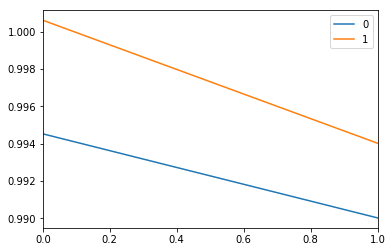

In [10]:
pd.DataFrame([GN_training_loss,GN_val_loss]).T.plot()

# Backtest

In [50]:
model_checkpoints_path_file = model_checkpoints_path+'-4587.meta'

backtester = Backtester(path_data=path_to_retrieve_samples,path_model_to_restore=model_checkpoints_path_file)

In [51]:
df_strats = backtester.run_backtest()

Textarea(value='', layout=Layout(border='1px solid #999999', height='200px', width='100%'))

INFO:tensorflow:Restoring parameters from model_checkpoints\ckpt-VWAP-1_week-2015_2017-32_pixels-4587
0.9875400544863563
1.0163028722833642
0.9741647849222808
0.9799359426232181
0.9775342881216942
0.9738898407728526
1.0229817191382724
1.0161630384246432
0.9415989546587156
0.965738699591357
0.9737417657426354
0.9652352537152566
0.927701009059654
0.9460954020779007
0.9989218322704897
0.9783954100122735


In [39]:
df_data = backtester._df_all_data
strategies = ['10_max_long', '20_max_long']

# Compute Returns
df_prices = df_data[['PRC', 'PERMNO']].pivot_table(columns='PERMNO', index='date')
df_rets = df_prices / df_prices.shift(1)
df_rets = df_rets.dropna()


In [47]:
df_rets['PRC']

PERMNO,83387.0,83390.0,83391.0,83399.0,83410.0,83411.0,83414.0,83422.0,83443.0,83445.0,...,85540.0,85567.0,85570.0,85576.0,85586.0,85592.0,85593.0,85604.0,85616.0,85621.0
date,,,,,,,,,,,,,,,,,,,,,
20181106,1.053993,0.950127,1.059302,1.034483,1.007951,0.981095,1.003891,0.898047,1.074551,0.980742,...,1.081081,1.141667,1.016468,1.161290,0.977391,1.004419,1.004255,1.005333,1.063758,1.066461
20181113,0.917823,0.987544,0.972119,0.980392,0.981366,0.962475,0.989203,1.049392,0.997300,0.994182,...,0.794842,0.950365,0.989199,1.027778,1.032918,1.024882,0.962995,1.010466,0.946372,1.021177
20181120,0.895349,0.993694,1.027552,0.912000,0.930380,0.958904,0.989645,0.938181,0.966915,1.058522,...,1.006489,1.190476,1.010919,0.990991,0.973299,0.987417,0.956635,0.997730,1.028889,0.991650
20181128,0.985714,1.012693,0.931868,0.982456,0.986395,0.965934,1.016403,1.022463,1.032224,0.969592,...,1.046053,1.013548,0.979298,1.118182,1.012168,1.009745,1.067949,1.016069,1.082073,1.064313
20181206,0.959157,0.984781,0.886792,0.886161,1.034483,0.941980,0.945743,0.955694,0.956138,1.049180,...,1.009434,0.987906,0.910846,1.048780,0.950820,1.016778,0.936462,0.997761,1.011976,0.981010
20181213,1.112637,0.954545,1.077128,0.979244,1.003333,0.903382,0.974110,0.983142,0.973360,1.031929,...,1.029595,0.949742,0.965691,0.941860,1.021609,0.950935,0.923048,0.978398,1.028600,0.982757
20181220,0.938272,0.953333,0.925926,0.969750,0.936877,0.877005,0.958321,0.969992,0.956328,1.075708,...,1.025719,0.852782,0.914316,0.827160,0.848015,0.927058,0.948963,0.975341,0.944391,0.922546
20181228,0.965789,1.053946,0.986667,0.984085,0.992908,1.062500,0.986133,0.983126,1.043909,0.973072,...,0.884956,0.842482,1.179429,1.139303,0.976495,0.968859,1.028605,0.942525,1.009137,1.007955


In [49]:
df_rets.PRC.loc[date][list_permnos_to_buy]

PERMNO
83762.0    0.831593
85539.0    0.935584
83844.0    1.024931
83885.0    1.030759
85077.0    1.067398
83690.0    1.041990
83532.0    1.000000
85337.0    0.957358
83976.0    1.041913
83486.0    1.052632
83651.0    1.057692
85540.0    0.884956
85349.0    0.999403
85467.0    0.954475
83390.0    1.053946
84737.0    0.945098
83630.0    0.741259
84581.0    1.000784
85340.0    1.004026
85205.0    1.028939
Name: 20181228, dtype: float64

In [43]:
df_results = pd.DataFrame(columns=strategies,index=backtester._df_permnos_to_buy.index)
for date in backtester._df_permnos_to_buy.index:
    for strat in strategies:
        list_permnos_to_buy = backtester._df_permnos_to_buy.loc[date][strat]
        print(df_rets.loc[date][list_permnos_to_buy].mean())
        df_results.loc[date][strat] = df_rets.loc[date][list_permnos_to_buy].mean()

[84825.0, 84516.0, 83414.0, 85464.0, 85390.0, 85172.0, 85418.0, 85604.0, 85440.0, 84734.0]
nan
[84825.0, 84516.0, 83414.0, 85464.0, 85390.0, 85172.0, 85418.0, 85604.0, 85440.0, 84734.0, 85332.0, 83651.0, 84656.0, 85459.0, 84181.0, 84185.0, 83969.0, 83443.0, 84381.0, 85299.0]
nan
[84511.0, 85205.0, 83443.0, 84519.0, 84819.0, 83969.0, 83879.0, 85621.0, 85293.0, 83989.0]
nan
[84511.0, 85205.0, 83443.0, 84519.0, 84819.0, 83969.0, 83879.0, 85621.0, 85293.0, 83989.0, 83883.0, 83462.0, 85176.0, 85576.0, 85257.0, 84176.0, 84737.0, 85604.0, 83486.0, 85059.0]
nan
[83916.0, 83520.0, 84397.0, 85234.0, 84226.0, 83909.0, 85259.0, 85205.0, 85340.0, 83547.0]
nan
[83916.0, 83520.0, 84397.0, 85234.0, 84226.0, 83909.0, 85259.0, 85205.0, 85340.0, 83547.0, 83422.0, 85592.0, 84255.0, 85440.0, 83656.0, 85077.0, 83450.0, 85526.0, 85586.0, 84010.0]
nan
[85567.0, 83486.0, 83728.0, 83630.0, 84268.0, 85285.0, 84206.0, 84210.0, 85272.0, 85604.0]
nan
[85567.0, 83486.0, 83728.0, 83630.0, 84268.0, 85285.0, 84206.0, 8

In [32]:
backtester._df_permnos_to_buy.shift(1)

,10_max_long,20_max_long
20181030,NaN,NaN
20181106,"[84825.0, 84516.0, 83414.0, 85172.0, 85390.0, ...","[84825.0, 84516.0, 83414.0, 85172.0, 85390.0, ..."
20181113,"[84511.0, 85205.0, 83443.0, 85176.0, 84519.0, ...","[84511.0, 85205.0, 83443.0, 85176.0, 84519.0, ..."
20181120,"[83916.0, 84397.0, 83520.0, 84226.0, 85340.0, ...","[83916.0, 84397.0, 83520.0, 84226.0, 85340.0, ..."
20181128,"[85567.0, 83486.0, 83630.0, 83728.0, 84210.0, ...","[85567.0, 83486.0, 83630.0, 83728.0, 84210.0, ..."
20181206,"[85348.0, 83883.0, 83443.0, 83597.0, 83509.0, ...","[85348.0, 83883.0, 83443.0, 83597.0, 83509.0, ..."
20181213,"[83445.0, 84607.0, 85205.0, 84083.0, 84581.0, ...","[83445.0, 84607.0, 85205.0, 84083.0, 84581.0, ..."
20181220,"[84819.0, 83883.0, 83520.0, 83391.0, 83909.0, ...","[84819.0, 83883.0, 83520.0, 83391.0, 83909.0, ..."
20181228,"[85539.0, 83762.0, 83844.0, 83532.0, 83885.0, ...","[85539.0, 83762.0, 83844.0, 83532.0, 83885.0, ..."


In [30]:
df_prices.shift(1)

PRC                                                          \
PERMNO   83387.0 83390.0 83391.0 83399.0 83410.0 83411.0 83414.0 83422.0   
date                                                                       
20181030     NaN     NaN     NaN     NaN     NaN     NaN     NaN     NaN   
20181106    8.89   11.83  0.8600  4.9300  1.5973   10.05   35.98   30.21   
20181113    9.37   11.24  0.9110  5.1000  1.6100    9.86   36.12   27.13   
20181120    8.60   11.10  0.8856  5.0000  1.5800    9.49   35.73   28.47   
20181128    7.70   11.03  0.9100  4.5600  1.4700    9.10   35.36   26.71   
20181206    7.59   11.17  0.8480  4.4800  1.4500    8.79   35.94   27.31   
20181213    7.28   11.00  0.7520  3.9700  1.5000    8.28   33.99   26.10   
20181220    8.10   10.50  0.8100  3.8876  1.5050    7.48   33.11   25.66   
20181228    7.60   10.01  0.7500  3.7700  1.4100    6.56   31.73   24.89   

                             ...                                           \
PERMNO      83443.0 83445.0  ... 85540.0 85567.0 85570.0 85576.0  85586.0   
date                         ...                                            
20181030        NaN     NaN  ...     NaN     NaN     NaN     NaN      NaN   
20181106  203.35001   14.02  ...  3.5150   12.00   10.93    1.86  23.0000   
20181113  218.50999   13.75  ...  3.8000   13.70   11.11    2.16  22.4800   
20181120  217.92000   13.67  ...  3.0204   13.02   10.99    2.22  23.2200   
20181128  210.71001   14.47  ...  3.0400   15.50   11.11    2.20  22.6000   
20181206  217.50000   14.03  ...  3.1800   15.71   10.88    2.46  22.8750   
20181213  207.96001   14.72  ...  3.2100   15.52    9.91    2.58  21.7500   
20181220  202.42000   15.19  ...  3.3050   14.74    9.57    2.43  22.2200   
20181228  193.58000   16.34  ...  3.3900   12.57    8.75    2.01  18.8429   

                                                     
PERMNO   85592.0 85593.0 85604.0 85616.0    85621.0  
date                                                 
20181030     NaN     NaN     NaN     NaN        NaN  
20181106   65.62  115.17   69.38    8.94  541.07001  
20181113   65.91  115.66   69.75    9.51  577.03003  
20181120   67.55  111.38   70.48    9.00  589.25000  
20181128   66.70  106.55   70.32    9.26  584.33002  
20181206   67.35  113.79   71.45   10.02  621.90997  
20181213   68.48  106.56   71.29   10.14  610.09998  
20181220   65.12   98.36   69.75   10.43  599.58002  
20181228   60.37   93.34   68.03    9.85  553.14001  

[9 rows x 200 columns]

In [24]:
backtester._df_permnos_to_buy


,10_max_long,20_max_long
20181030,"[84825.0, 83414.0, 84516.0, 85390.0, 85418.0, ...","[84825.0, 83414.0, 84516.0, 85390.0, 85418.0, ..."
20181106,"[85205.0, 84511.0, 83443.0, 85293.0, 85176.0, ...","[85205.0, 84511.0, 83443.0, 85293.0, 85176.0, ..."
20181113,"[83916.0, 83909.0, 83520.0, 84397.0, 84226.0, ...","[83916.0, 83909.0, 83520.0, 84397.0, 84226.0, ..."
20181120,"[85567.0, 83486.0, 83728.0, 83630.0, 85285.0, ...","[85567.0, 83486.0, 83728.0, 83630.0, 85285.0, ..."
20181128,"[83883.0, 85348.0, 83509.0, 83443.0, 85390.0, ...","[83883.0, 85348.0, 83509.0, 83443.0, 85390.0, ..."
20181206,"[83445.0, 85205.0, 84083.0, 84581.0, 84413.0, ...","[83445.0, 85205.0, 84083.0, 84581.0, 84413.0, ..."
20181213,"[84819.0, 83883.0, 83391.0, 84519.0, 83909.0, ...","[84819.0, 83883.0, 83391.0, 84519.0, 83909.0, ..."
20181220,"[85539.0, 83762.0, 83844.0, 83885.0, 85077.0, ...","[85539.0, 83762.0, 83844.0, 83885.0, 85077.0, ..."
20181228,"[83486.0, 85517.0, 85246.0, 85348.0, 84381.0, ...","[83486.0, 85517.0, 85246.0, 85348.0, 84381.0, ..."


In [105]:
df_backt = backtester._df_all_data

In [129]:
df_backt[['long','PERMNO']].reset_index().set_index(['date','PERMNO']).loc[20181030].sort_values(by='long',ascending=False).index[:10]

Float64Index([68292.0, 75070.0, 67598.0, 65947.0, 72338.0, 63706.0, 64785.0,
              66683.0, 66157.0, 75033.0],
             dtype='float64', name='PERMNO')

In [205]:
df_backt[['long','PERMNO']].reset_index().set_index(['date','PERMNO']).loc[20181030].sort_values(by='long',ascending=False)#.index[:10]

,long
PERMNO,
68292.0,0.867475
75070.0,0.783997
67598.0,0.777951
65947.0,0.775851
72338.0,0.752948
63706.0,0.731680
64785.0,0.731118
66683.0,0.725403
66157.0,0.712569


In [202]:
df_backt[['long','PERMNO']].pivot_table(columns='PERMNO',index='date')#['PRC'][64805.]

long                                                    \
PERMNO     60709.0   60871.0   60943.0   60986.0   61146.0   61188.0   
date                                                                   
20181030  0.315943  0.600344  0.178019  0.140866  0.072415  0.304995   
20181106  0.271573  0.353637  0.495792  0.638277  0.320034  0.558968   
20181113  0.188821  0.185212  0.221460  0.324065  0.077895  0.449854   
20181120  0.265777  0.309785  0.376972  0.479211  0.204357  0.206988   
20181128  0.500613  0.407016  0.410122  0.574189  0.668138  0.087803   
20181206  0.368135  0.194534  0.344489  0.182016  0.220767  0.523737   
20181213  0.113500  0.266274  0.187131  0.393145  0.443834  0.545097   
20181220  0.265270  0.114955  0.276112  0.187116  0.288885  0.121923   
20181228  0.279732  0.575029  0.655212  0.264917  0.693992  0.434108   

                                                  ...                      \
PERMNO     61241.0   61269.0   61313.0   61399.0  ...   75470.0   75475.0   
date                                              ...                       
20181030  0.079961  0.193599  0.390356  0.095333  ...  0.430672  0.173223   
20181106  0.444584  0.559146  0.456007  0.492766  ...  0.215561  0.360847   
20181113  0.192356  0.259878  0.158797  0.139750  ...  0.194760  0.183285   
20181120  0.145391  0.163135  0.254601  0.109347  ...  0.180031  0.103015   
20181128  0.505816  0.312134  0.478209  0.664726  ...  0.475059  0.413035   
20181206  0.276573  0.161711  0.076723  0.164679  ...  0.088995  0.297636   
20181213  0.303409  0.263578  0.327404  0.494464  ...  0.385738  0.235790   
20181220  0.153684  0.136792  0.166661  0.228485  ...  0.172820  0.055705   
20181228  0.485685  0.503946  0.651662  0.702147  ...  0.569266  0.593527   

                                                                      \
PERMNO     75510.0   75517.0   75556.0   75573.0   75578.0   75591.0   
date                                                                   
20181030  0.110015  0.568042  0.180543  0.224212  0.072991  0.136528   
20181106  0.227633  0.382436  0.251338  0.484303  0.122715  0.536677   
20181113  0.100785  0.166055  0.291030  0.274076  0.085821  0.157545   
20181120  0.105943  0.307334  0.078981  0.105045  0.133143  0.276087   
20181128  0.676037  0.239135  0.436666  0.732217  0.469964  0.442980   
20181206  0.215968  0.075266  0.261697  0.173839  0.278939  0.221072   
20181213  0.330182  0.131843  0.313976  0.291139  0.131839  0.437504   
20181220  0.197919  0.178728  0.159039  0.080203  0.156765  0.108917   
20181228  0.663387  0.687280  0.642225  0.633511  0.553842  0.658852   

                              
PERMNO     75603.0   75605.0  
date                          
20181030  0.633086  0.653608  
20181106  0.495520  0.290627  
20181113  0.070086  0.225380  
20181120  0.303034  0.399705  
20181128  0.253784  0.540119  
20181206  0.355745  0.058751  
20181213  0.182889  0.312870  
20181220  0.081764  0.122259  
20181228  0.448094  0.344511  

[9 rows x 200 columns]

In [207]:
df_prices['PRC'][75070.]

date
20181030    31.74
20181106    30.62
20181113    27.87
20181120    25.91
20181128    26.30
20181206    24.28
20181213    23.03
20181220    21.52
20181228    20.78
Name: 75070.0, dtype: float64

In [14]:
df_prices = backtester._df_all_data[['PRC','PERMNO']].pivot_table(columns='PERMNO',index='date')
df_prices

PRC                                                          \
PERMNO   83387.0 83390.0 83391.0 83399.0 83410.0 83411.0 83414.0 83422.0   
date                                                                       
20181030    8.89   11.83  0.8600  4.9300  1.5973   10.05   35.98   30.21   
20181106    9.37   11.24  0.9110  5.1000  1.6100    9.86   36.12   27.13   
20181113    8.60   11.10  0.8856  5.0000  1.5800    9.49   35.73   28.47   
20181120    7.70   11.03  0.9100  4.5600  1.4700    9.10   35.36   26.71   
20181128    7.59   11.17  0.8480  4.4800  1.4500    8.79   35.94   27.31   
20181206    7.28   11.00  0.7520  3.9700  1.5000    8.28   33.99   26.10   
20181213    8.10   10.50  0.8100  3.8876  1.5050    7.48   33.11   25.66   
20181220    7.60   10.01  0.7500  3.7700  1.4100    6.56   31.73   24.89   
20181228    7.34   10.55  0.7400  3.7100  1.4000    6.97   31.29   24.47   

                             ...                                           \
PERMNO      83443.0 83445.0  ... 85540.0 85567.0 85570.0 85576.0  85586.0   
date                         ...                                            
20181030  203.35001   14.02  ...  3.5150   12.00   10.93    1.86  23.0000   
20181106  218.50999   13.75  ...  3.8000   13.70   11.11    2.16  22.4800   
20181113  217.92000   13.67  ...  3.0204   13.02   10.99    2.22  23.2200   
20181120  210.71001   14.47  ...  3.0400   15.50   11.11    2.20  22.6000   
20181128  217.50000   14.03  ...  3.1800   15.71   10.88    2.46  22.8750   
20181206  207.96001   14.72  ...  3.2100   15.52    9.91    2.58  21.7500   
20181213  202.42000   15.19  ...  3.3050   14.74    9.57    2.43  22.2200   
20181220  193.58000   16.34  ...  3.3900   12.57    8.75    2.01  18.8429   
20181228  202.08000   15.90  ...  3.0000   10.59   10.32    2.29  18.4000   

                                                     
PERMNO   85592.0 85593.0 85604.0 85616.0    85621.0  
date                                                 
20181030   65.62  115.17   69.38    8.94  541.07001  
20181106   65.91  115.66   69.75    9.51  577.03003  
20181113   67.55  111.38   70.48    9.00  589.25000  
20181120   66.70  106.55   70.32    9.26  584.33002  
20181128   67.35  113.79   71.45   10.02  621.90997  
20181206   68.48  106.56   71.29   10.14  610.09998  
20181213   65.12   98.36   69.75   10.43  599.58002  
20181220   60.37   93.34   68.03    9.85  553.14001  
20181228   58.49   96.01   64.12    9.94  557.53998  

[9 rows x 200 columns]

In [15]:
df_rets = df_prices/df_prices.shift(1)
df_rets

PRC                                                    \
PERMNO     83387.0   83390.0   83391.0   83399.0   83410.0   83411.0   
date                                                                   
20181030       NaN       NaN       NaN       NaN       NaN       NaN   
20181106  1.053993  0.950127  1.059302  1.034483  1.007951  0.981095   
20181113  0.917823  0.987544  0.972119  0.980392  0.981366  0.962475   
20181120  0.895349  0.993694  1.027552  0.912000  0.930380  0.958904   
20181128  0.985714  1.012693  0.931868  0.982456  0.986395  0.965934   
20181206  0.959157  0.984781  0.886792  0.886161  1.034483  0.941980   
20181213  1.112637  0.954545  1.077128  0.979244  1.003333  0.903382   
20181220  0.938272  0.953333  0.925926  0.969750  0.936877  0.877005   
20181228  0.965789  1.053946  0.986667  0.984085  0.992908  1.062500   

                                                  ...                      \
PERMNO     83414.0   83422.0   83443.0   83445.0  ...   85540.0   85567.0   
date                                              ...                       
20181030       NaN       NaN       NaN       NaN  ...       NaN       NaN   
20181106  1.003891  0.898047  1.074551  0.980742  ...  1.081081  1.141667   
20181113  0.989203  1.049392  0.997300  0.994182  ...  0.794842  0.950365   
20181120  0.989645  0.938181  0.966915  1.058522  ...  1.006489  1.190476   
20181128  1.016403  1.022463  1.032224  0.969592  ...  1.046053  1.013548   
20181206  0.945743  0.955694  0.956138  1.049180  ...  1.009434  0.987906   
20181213  0.974110  0.983142  0.973360  1.031929  ...  1.029595  0.949742   
20181220  0.958321  0.969992  0.956328  1.075708  ...  1.025719  0.852782   
20181228  0.986133  0.983126  1.043909  0.973072  ...  0.884956  0.842482   

                                                                      \
PERMNO     85570.0   85576.0   85586.0   85592.0   85593.0   85604.0   
date                                                                   
20181030       NaN       NaN       NaN       NaN       NaN       NaN   
20181106  1.016468  1.161290  0.977391  1.004419  1.004255  1.005333   
20181113  0.989199  1.027778  1.032918  1.024882  0.962995  1.010466   
20181120  1.010919  0.990991  0.973299  0.987417  0.956635  0.997730   
20181128  0.979298  1.118182  1.012168  1.009745  1.067949  1.016069   
20181206  0.910846  1.048780  0.950820  1.016778  0.936462  0.997761   
20181213  0.965691  0.941860  1.021609  0.950935  0.923048  0.978398   
20181220  0.914316  0.827160  0.848015  0.927058  0.948963  0.975341   
20181228  1.179429  1.139303  0.976495  0.968859  1.028605  0.942525   

                              
PERMNO     85616.0   85621.0  
date                          
20181030       NaN       NaN  
20181106  1.063758  1.066461  
20181113  0.946372  1.021177  
20181120  1.028889  0.991650  
20181128  1.082073  1.064313  
20181206  1.011976  0.981010  
20181213  1.028600  0.982757  
20181220  0.944391  0.922546  
20181228  1.009137  1.007955  

[9 rows x 200 columns]

In [166]:
df_res = df_res.dropna()

In [167]:
df_res

,permnos
20181106,"[68292.0, 75070.0, 67598.0, 65947.0, 72338.0, ..."
20181113,"[74500.0, 63132.0, 62156.0, 63765.0, 61946.0, ..."
20181120,"[75069.0, 64936.0, 65947.0, 64450.0, 75033.0, ..."
20181128,"[64936.0, 71837.0, 75313.0, 61946.0, 66683.0, ..."
20181206,"[64186.0, 63125.0, 62092.0, 63773.0, 75573.0, ..."
20181213,"[75260.0, 70826.0, 75331.0, 75313.0, 75239.0, ..."
20181220,"[67847.0, 75039.0, 75261.0, 74740.0, 64899.0, ..."
20181228,"[62391.0, 66800.0, 69446.0, 64653.0, 66245.0, ..."


In [189]:
df_res.loc[date][0]

[68292.0,
 75070.0,
 67598.0,
 65947.0,
 72338.0,
 63706.0,
 64785.0,
 66683.0,
 66157.0,
 75033.0]

In [190]:
dic ={}
for date in df_res.index:
    dic[date] = df_rets.loc[date][df_res.loc[date][0]].mean()

In [17]:
sorted(set(backtester._df_all_data.index))

[20181030,
 20181106,
 20181113,
 20181120,
 20181128,
 20181206,
 20181213,
 20181220,
 20181228]

In [18]:
backtester._df_permnos_to_buy.loc[20181120]['permnos']

[85567.0,
 83486.0,
 83728.0,
 84210.0,
 85285.0,
 83630.0,
 84268.0,
 85272.0,
 83604.0,
 84206.0]

In [212]:
df_result = pd.DataFrame.from_dict(dic,orient='index')
df_result

,0
20181106,0.987516
20181113,0.995286
20181120,0.995290
20181128,0.998690
20181206,0.964398
20181213,0.988751
20181220,0.762653
20181228,0.995389


In [233]:
handler.df_data.ASKHI

PERMNO
60709     2.1500
60709     2.1800
60709     2.1800
60709     2.4000
60709     2.3987
60709     2.3000
60709     2.3500
60709     2.2899
60709     2.2700
60709     2.2800
60709     2.2581
60709     2.3000
60709     2.3400
60709     2.3500
60709     2.3528
60709     2.5200
60709     2.5700
60709     2.6000
60709     2.5000
60709     2.4826
60709     2.4200
60709     2.4700
60709     2.4700
60709     2.3964
60709     2.3300
60709     2.3500
60709     2.3200
60709     2.2900
60709     2.2999
60709     2.2790
          ...   
75605    41.2700
75605    41.3800
75605    42.8200
75605    41.6500
75605    41.5600
75605    41.3100
75605    42.1200
75605    41.5000
75605    42.1900
75605    42.5300
75605    42.1200
75605    42.4900
75605    42.0150
75605    39.2400
75605    39.8000
75605    39.2500
75605    38.9700
75605    39.4800
75605    39.4600
75605    37.9500
75605    36.7150
75605    36.9300
75605    35.8900
75605    34.3800
75605    34.6885
75605    33.8950
75605    34.2900
75605  

In [237]:
handler.df_data[handler.df_data['VOL']<0]

,date,PRC,ASKHI,BIDLO,VOL
PERMNO,,,,,


In [225]:
df_prices['PRC'][64899]

date
20181030    199.00000
20181106   -205.77000
20181113   -201.85500
20181120   -192.94501
20181128    200.86940
20181206   -192.80499
20181213    181.83000
20181220   -167.86501
20181228    164.67999
Name: 64899.0, dtype: float64

In [223]:
df_rets.loc[20181220].sort_values()

PERMNO
64899.0   -0.923198
62376.0    0.732258
62368.0    0.736842
63335.0    0.790576
63781.0    0.809368
75573.0    0.820423
75047.0    0.821693
61815.0    0.829150
63765.0    0.833735
65285.0    0.836040
64822.0    0.836326
72304.0    0.837517
67838.0    0.838329
70332.0    0.841113
64186.0    0.848313
62922.0    0.856252
65270.0    0.856423
62341.0    0.856753
64805.0    0.858445
75416.0    0.859065
75065.0    0.872856
64629.0    0.873518
64961.0    0.873708
71159.0    0.878806
60986.0    0.879280
75154.0    0.879837
75510.0    0.881369
73139.0    0.889679
75578.0    0.889680
68187.0    0.889682
             ...   
75381.0    0.988701
75260.0    0.989160
71271.0    0.989513
60709.0    0.991770
67598.0    0.992069
75411.0    0.992936
70228.0    0.993260
71475.0    0.993589
75239.0    0.994505
65700.0    0.994902
73219.0    0.995444
75342.0    0.995682
69892.0    1.000000
66245.0    1.000000
75075.0    1.000000
75069.0    1.002454
74740.0    1.003968
70092.0    1.013111
61807.0    1.

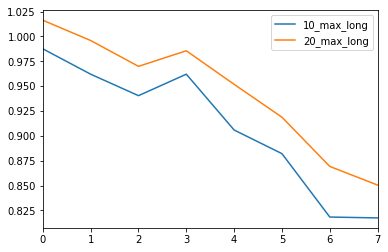

In [55]:
df_strats.reset_index().cumprod().plot()

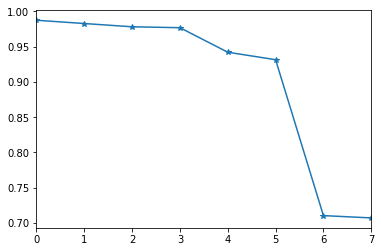

In [218]:
df_result.reset_index()[0].cumprod().plot(style='*-')

In [22]:
(Y_val.shape,Y_train.shape,Y_test.shape)

((4089, 3), (8175, 3), (4086, 3))

In [144]:
df_signals = pd.DataFrame(GN_pred,columns = ['long','hold','short'])
df_signals['PRC'] = df_bckt_val['PRC'].values
df_signals['date'] = df_bckt_val.index
df_signals['PERMNO'] = df_bckt_val['PERMNO'].values
df_signals = df_signals.set_index('date')
df_signals = df_signals.sort_index().reset_index().set_index(['date','PERMNO'])

In [194]:
5450/2


2725.0

In [197]:
from utils import load_pickle

df_all_data = load_pickle(os.path.join(path_to_dump_samples,'image_data_1')).iloc[round(0.75 * 2725 * 2/3):round(0.75 * 2725):][['PRC','PERMNO']]
df_all_data = pd.concat([df_all_data,load_pickle(os.path.join(path_to_dump_samples,'image_data_2')).iloc[round(0.75 * 2725 * 2/3):round(0.75 * 2725):][['PRC','PERMNO']]])

Textarea(value='', layout=Layout(border='1px solid #999999', height='200px', width='100%'))

In [210]:
len(np.unique(df_all_data['PERMNO']))

50

In [211]:
pd.concat([df_all_data,df_signals],axis=1).reset_index().set_index(['date','PERMNO']).sort_index()


PRC      long      hold     short
date     PERMNO                                          
20161128 77066.0   13.28000  0.401298  0.204361  0.394340
         77069.0   13.53000  0.540051  0.185258  0.274691
         77071.0   14.81000  0.527627  0.203407  0.268966
         77073.0   13.76000  0.429708  0.247666  0.322626
         77078.0   46.40000  0.432216  0.294398  0.273385
         77090.0   75.40000  0.275308  0.367900  0.356792
         77114.0   58.17000  0.265527  0.387700  0.346772
         77117.0   13.42000  0.345440  0.263185  0.391375
         77120.0   39.75000  0.302770  0.384327  0.312903
         77124.0   14.42000  0.404172  0.251088  0.344740
         77129.0   26.25000  0.480424  0.220867  0.298709
         77131.0   12.14000  0.515955  0.214232  0.269813
         77152.0   14.01000  0.481184  0.226358  0.292458
         77274.0   74.54000  0.394546  0.307601  0.297852
         77279.0   51.93000  0.411895  0.330363  0.257742
         77282.0    9.45000  0.293484  0.378543  0.327972
         77292.0    2.40000  0.544599  0.192922  0.262479
         77300.0   90.17000  0.254040  0.378325  0.367634
         77309.0   10.57900  0.451743  0.219852  0.328405
         77316.0   12.63000  0.477437  0.204514  0.318049
         77338.0  182.08000  0.322391  0.324847  0.352761
         77354.0   45.77000  0.288136  0.418540  0.293324
         77357.0   61.30000  0.307902  0.365052  0.327046
         77366.0   12.34000  0.315582  0.341641  0.342777
         77369.0   16.90000  0.403948  0.273576  0.322476
         77377.0    9.55000  0.523460  0.198571  0.277969
20161205 77066.0   13.35000  0.518125  0.152034  0.329841
         77069.0   13.18000  0.519409  0.201938  0.278654
         77071.0   14.56000  0.509981  0.206410  0.283608
         77073.0   13.40000  0.520846  0.193412  0.285742
...                     ...       ...       ...       ...
20170613 77124.0   14.75000  0.458379  0.253640  0.287981
         77152.0   14.83000  0.355363  0.385341  0.259296
         77178.0   57.54000  0.441620  0.341503  0.216877
         77182.0   71.70000  0.482742  0.290642  0.226616
         77191.0   46.50000  0.214098  0.423177  0.362725
         77205.0    3.32000  0.617116  0.239950  0.142934
         77235.0    1.61000  0.232648  0.431922  0.335430
         77236.0   23.45000  0.331632  0.412514  0.255854
         77239.0   35.58000  0.318508  0.379393  0.302099
         77256.0   34.31000  0.313227  0.343747  0.343025
         77259.0    2.09690  0.392964  0.324210  0.282826
         77274.0   65.15000  0.450057  0.222203  0.327740
         77279.0   51.67000  0.232551  0.417113  0.350337
         77282.0    9.60000  0.490865  0.245981  0.263154
         77292.0    2.34000  0.426247  0.349192  0.224561
         77300.0   89.83000  0.500873  0.206692  0.292435
         77309.0   12.34720  0.330237  0.401749  0.268014
         77316.0   13.30000  0.265219  0.518703  0.216078
         77338.0  228.42999  0.375727  0.377408  0.246865
         77357.0   74.66000  0.396049  0.348526  0.255425
         77377.0    9.84000  0.322773  0.353473  0.323753
         77420.0   11.15000  0.560683  0.154894  0.284424
         77425.0    6.45000  0.536118  0.215958  0.247924
         77437.0    2.11000  0.598217  0.163214  0.238569
         77447.0  168.39999  0.359461  0.362606  0.277933
         77453.0  106.68000  0.371528  0.374740  0.253733
         77458.0    8.81000  0.246783  0.501944  0.251274
         77460.0    5.36000  0.482326  0.272441  0.245233
         77462.0   22.26000  0.413815  0.217851  0.368334
         77466.0   15.23000  0.268838  0.470001  0.261161

[1364 rows x 4 columns]

+ we need a dataframe with rebalance dates as index, permno as columns as prices as data (or inverse columns and index)
+ Then 

+ Load a model in order to make the predictions within the backtest

In [43]:
df_for_bckt = df_for_bckt[['PRC']]

In [49]:
df_pivot = df_for_bckt.reset_index().pivot_table(columns=['PERMNO'],index='date')

In [54]:
df_pivot.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 755 entries, 20150102 to 20171229
Columns: 1350 entries, (PRC, 10026) to (PRC, 87952)
dtypes: float64(1350)
memory usage: 7.8 MB


In [52]:
df_pivot.head()

PRC                                                            \
PERMNO     10026  10032  10044  10065  10104   10107  10138   10145  10182   
date                                                                         
20150102  107.69  40.57  13.23  13.67  44.33  46.760  85.76  100.23  62.20   
20150105  107.24  39.65  13.26  13.42  43.59  46.325  83.79   98.32  60.39   
20150106  107.27  39.11  13.22  13.35  43.14  45.650  82.31   98.09  58.77   
20150107  108.73  39.44  13.27  13.47  43.15  46.230  83.52   98.80  59.09   
20150108  110.32  40.01  13.12  13.71  43.41  47.590  84.51  100.60  60.35   

                 ...                                                      \
PERMNO    10200  ...  85789  85914  86106  86124  86896      87055 87128   
date             ...                                                       
20150102  20.10  ...  22.25  38.79  40.55  30.73  37.71  141.61000  8.01   
20150105  20.47  ...  21.45  37.79  39.18  30.14  36.76  140.00000  7.66   
20150106  19.86  ...  20.85  37.45  38.44  29.92  36.05  141.85001  7.54   
20150107  19.92  ...  20.88  38.53  38.50  30.11  36.24  144.32001  7.56   
20150108  24.52  ...  21.47  39.11  39.24  30.24  36.76  145.56000  7.60   

                               
PERMNO    87426  87717  87952  
date                           
20150102  49.97  44.42  27.47  
20150105  49.41  43.04  26.51  
20150106  48.33  42.55  25.74  
20150107  47.99  42.56  25.72  
20150108  48.95  43.72  26.40  

[5 rows x 1350 columns]

+ we need a dataframe for the signals with additional columsn ( or multiindex) with permno and date
+ find a way when creating the predictions to keep the information about dates and permno
    * For that we may need to change the function get_data from path (maybe it should return a dataframe (at least for the Y) and it would be transformed into an array
    * For X maybe we could have a pivot table (date,permon) and the values would be arrays of (16,16,4)
   

In [59]:
X_train1.shape

(91763, 32, 32, 4)

In [62]:
df_pivot.values.shape

(755, 1350)

In [19]:
df_for_bckt = handler.df_data
df_for_bckt = df_for_bckt.reset_index(drop=False).set_index(['PERMNO','date'])
df_for_bckt.head()

PRC        VOL    BIDLO     ASKHI
PERMNO date                                             
22592  20150102  164.06000  2117562.0  162.730  165.0800
       20150105  160.36000  3692901.0  160.080  163.6400
       20150106  158.64999  3537144.0  157.744  161.3699
       20150107  159.80000  3081291.0  158.940  160.2800
       20150108  163.63000  3149592.0  160.520  163.6900

In [20]:
df_for_bckt.reset_index(level=0, drop=False).reset_index(drop=False)

,date,PERMNO,PRC,VOL,BIDLO,ASKHI
0,20150102,22592,164.06000,2117562.0,162.73000,165.08000
1,20150105,22592,160.36000,3692901.0,160.08000,163.64000
2,20150106,22592,158.64999,3537144.0,157.74400,161.36990
3,20150107,22592,159.80000,3081291.0,158.94000,160.28000
4,20150108,22592,163.63000,3149592.0,160.52000,163.69000
5,20150109,22592,161.62000,2378568.0,161.27000,164.00000
6,20150112,22592,160.74001,2149230.0,160.02000,162.39000
7,20150113,22592,160.62000,2706698.0,159.45000,164.38400
8,20150114,22592,159.84000,1983535.0,158.50000,160.53000
9,20150115,22592,159.66000,1881406.0,159.36749,161.44000


In [35]:
import numpy as np
import pandas as pd
import pickle
import numexpr as ne
import matplotlib.pyplot as plt
from functools import partial
import os 
import re
from data.data_processing import generate_dummy_data,DataHandler,get_training_data_from_path


%load_ext autoreload
%autoreload 2
%matplotlib inline

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [66]:
folder_for_samples = 'data/cnn_samples'
path_to_dump_samples = os.path.join(folder_for_samples,'VWAP-1_week-2015_2017-all_stocks-32_pixels')


handler = DataHandler(encoding_method='GADF', window_len=64, image_size=32, retrain_freq=5,
                 start_date = 20150102, end_date= 20200102, frac_of_stocks=1.,
                stock_data_dir_path= 'data/stock_data',
                 dir_for_samples=path_to_dump_samples, nb_of_stocks_by_file=50,
                      kwargs_target_methods = {'up_return':0.011,'down_return':-0.010}
                 )

handler.get_df_data()
df = handler.df_data


df = df.reset_index(drop=False).set_index(['PERMNO','date'])
all_permno = np.unique([x[0] for x in df.index.values])[:1350]
all_dates = np.unique([x[1] for x in df.index.values])

Textarea(value='', layout=Layout(border='1px solid #999999', height='200px', width='100%'))

In [73]:
from utils import load_pickle

In [76]:
dict_pickle = load_pickle('data/cnn_samples/VWAP-1_week-2015_2017-all_stocks-32_pixels/image_data_1')

Textarea(value='', layout=Layout(border='1px solid #999999', height='200px', width='100%'))

In [83]:
dict_pickle['VWAP_targets'].shape

(7538, 3)

In [85]:
37750/5

7550.0

## We need to have a key df_data_for_backtest in the pickle with exactly the same shape as _targets
## Thus we will be able to put the predictions directly into a dataframe with corresponding permno and dates

In [84]:
dict_pickle['df_original_data'][['PRC','PERMNO']].shape

(37750, 2)

In [72]:
handler.df_data.head()

,date,PRC,VOL,BIDLO,ASKHI
PERMNO,,,,,
80320,20150102,36.58,624950.0,36.10,36.82
80320,20150105,36.22,537218.0,35.96,36.59
80320,20150106,35.81,393701.0,35.44,36.40
80320,20150107,35.92,355461.0,35.60,36.07
80320,20150108,36.29,510670.0,36.03,36.45


In [65]:
signals.shape

(10000, 3)

In [37]:
image_size = 16 # Compress information for every 4 days;
data_len = int(252/4)+1
retrain_freq = 5
nDays = len(all_dates)

signals = pd.DataFrame(GN_pred)
signals.columns = [['long', 'hold', 'short']]


rebalance_dates = [all_dates[i] for i in range(data_len, nDays, retrain_freq)]
rebalance_dates = rebalance_dates[int(len(rebalance_dates)*2/3)+1:]
n = len(rebalance_dates)


signals['PERMNO'] = np.array([[x]*n for x in all_permno]).ravel()
signals['rebalance_dates'] = rebalance_dates*1350

df1 = df.reset_index(level=0, drop=False).reset_index(drop=False)
iv = df1.date
prc_dict = {x: df1[ne.evaluate('iv==x')][['PRC', 'PERMNO']] for x in rebalance_dates}

ValueError: Length of values does not match length of index

In [ ]:
iv = signals.rebalance_dates
signal_dict = {x: signals[ne.evaluate('iv==x')][['long', 'hold', 'short', 'PERMNO']] for x in rebalance_dates}

# Little tests section

In [45]:
tf.device

<function tensorflow.python.framework.ops.device(device_name_or_function)>

In [47]:
from tensorflow.python.client import device_lib 
print(device_lib.list_local_devices())

[name: "/device:CPU:0"
device_type: "CPU"
memory_limit: 268435456
locality {
}
incarnation: 6690035029401750070
]


In [30]:
import tensorflow as tf

In [8]:
tf.train.latest_checkpoint('model_checkpoints')

'model_checkpoints\\ckpt-266'

In [13]:

# with tf.variable_scope('test',reuse=tf.AUTO_REUSE):
#     network2 = CondensedGoogLeNet(shape_x=shape_x,shape_y=shape_y,hyperparams=GoogleNet_hyperparams)
#     network2.build_operations()
sess=tf.Session()    
#First let's load meta graph and restore weights
# saver = tf.train.import_meta_graph('model_checkpoints/ckpt1-266.meta')
saver = tf.train.import_meta_graph('model_checkpoints/ckpt-26.meta')
saver.restore(sess,tf.train.latest_checkpoint('model_checkpoints'))

INFO:tensorflow:Restoring parameters from model_checkpoints\ckpt-26


In [14]:
graph = tf.get_default_graph()
# w1 = graph.get_tensor_by_name("w1:0")
# w2 = graph.get_tensor_by_name("w2:0")
# feed_dict ={w1:13.0,w2:17.0}



+ CondensedGoogLeNet/loss/Mean gets the loss
+ CondensedGoogLeNet/Adam gets the optimizer
+ CondensedGoogLeNet/accuracy/Mean gets the accuracy
    + we can get the validation error just after
+ CondensedGoogLeNet/Merge/MergeSummary gets the summary op
+ CondensedGoogLeNet/init gets init_op
+ 

In [15]:
output = graph.get_tensor_by_name('CondensedGoogLeNet/output:0')
train_op = graph.get_tensor_by_name('CondensedGoogLeNet/minimize:0')
x = graph.get_tensor_by_name('CondensedGoogLeNet/x:0')
y = graph.get_tensor_by_name('CondensedGoogLeNet/y:0')
global_step = graph.get_tensor_by_name('CondensedGoogLeNet/global_step:0')
# loss = graph.get_tensor_by_name('CondensedGoogLeNet/loss/Mean:0')

In [18]:
pred = sess.run([train_op,global_step],feed_dict={x:X_val[:100],y:Y_val[:100]})

In [19]:
pred

[28, 28]

In [62]:
network.optimizer

<tf.Operation 'CondensedGoogLeNet/minimize' type=AssignAdd>

In [99]:
# train_op = graph.get_tensor_by_name('CondensedGoogLeNet/minimize:0')


In [49]:
train_op

<tf.Tensor 'CondensedGoogLeNet/Adam:0' shape=() dtype=int32_ref>

In [47]:
pred

408

In [48]:
pred = sess.run(output,feed_dict={x:X_val1[:15]})
pred

array([[0.54534346, 0.31630963, 0.13834698],
       [0.24215752, 0.27100408, 0.48683837],
       [0.19895326, 0.2448365 , 0.5562103 ],
       [0.46735036, 0.3460878 , 0.18656184],
       [0.28557023, 0.5997592 , 0.11467056],
       [0.3116192 , 0.43605033, 0.25233048],
       [0.21186991, 0.61546487, 0.17266521],
       [0.23539183, 0.67194796, 0.09266017],
       [0.12098232, 0.7968117 , 0.08220595],
       [0.13915536, 0.7540392 , 0.10680544],
       [0.26458594, 0.61498356, 0.1204305 ],
       [0.2907207 , 0.5771785 , 0.13210084],
       [0.18505928, 0.5521796 , 0.26276112],
       [0.20635134, 0.5497223 , 0.2439263 ],
       [0.28695482, 0.5000306 , 0.2130146 ]], dtype=float32)

In [20]:
saver.save(sess,'model_checkpoints/test_restore')

'model_checkpoints/test_restore'

array([[<matplotlib.axes._subplots.AxesSubplot object at 0x000001EB8140E128>]],
      dtype=object)

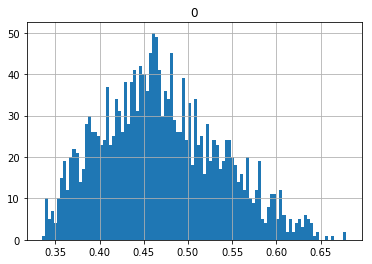

In [61]:
pd.DataFrame(np.max(pred,axis=1)).hist(bins=100)

In [46]:
pred[:5]

array([[0.37601736, 0.38016203, 0.24382067],
       [0.33472654, 0.37284032, 0.2924331 ],
       [0.35309193, 0.30750227, 0.33940583],
       [0.3471133 , 0.32821226, 0.3246745 ],
       [0.3240848 , 0.3507759 , 0.3251393 ]], dtype=float32)

In [42]:
GN_pred[:5]

array([[0.38847148, 0.36652684, 0.24500167],
       [0.32993904, 0.42600474, 0.24405627],
       [0.32316726, 0.3760524 , 0.30078036],
       [0.33141774, 0.36307806, 0.3055042 ],
       [0.36576766, 0.33067912, 0.30355325]], dtype=float32)

In [43]:
Y_val[:5]

array([[0, 1, 0],
       [0, 1, 0],
       [0, 1, 0],
       [1, 0, 0],
       [0, 1, 0]])

In [16]:
pred.shape

(1885, 3)

In [ ]:
tf.reset_default_graph()

# Create some variables.
v1 = tf.get_variable("v1", shape=[3])
v2 = tf.get_variable("v2", shape=[5])

# Add ops to save and restore all the variables.
saver = tf.train.Saver()

# Later, launch the model, use the saver to restore variables from disk, and
# do some work with the model.
with tf.Session() as sess:
  # Restore variables from disk.
  saver.restore(sess, "/tmp/model.ckpt")
  print("Model restored.")
  # Check the values of the variables
  print("v1 : %s" % v1.eval())
  print("v2 : %s" % v2.eval())

In [ ]:
tf.train.latest_checkpoint

In [3]:
tf.train.import_meta_graph

5